In [1]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np

In [28]:
type(probabilityCurve)

QuantLib.QuantLib.RelinkableDefaultProbabilityTermStructureHandle

In [27]:
isinstance(discountCurve, ql.YieldTermStructureHandle)

True

In [29]:
notional: float = 10_000_000
spread: float = 0.0458
recovery: float = 0.25
trade_date: ql.Date = ql.Date(9, 5, 2024)
termDate: ql.Date = ql.Date(20, 6, 2029)
protection_side: bool = ql.Protection.Buyer

dep_tenors = [1, 2, 3, 6, 12]
dep_quotes = [
    0.053209,
    0.053240,
    0.053256,
    0.05293,
    0.051551,
]
swap_tenors = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]
swap_quotes = [
    0.047535,
    0.045104,
    0.043555,
    0.042585,
    0.041992,
    0.041649,
    0.041395,
    0.041235,
    0.041149,
    0.041115,
    0.041111,
    0.040735,
    0.039775,
    0.038805,
]

ql.Settings.instance().evaluationDate = trade_date
ql.IborCoupon.createAtParCoupons()


isdaRateHelpers: list[ql.DepositRateHelper] = [
    ql.DepositRateHelper(
        quote,
        tenor * ql.Period(ql.Monthly),
        2,
        ql.WeekendsOnly(),
        ql.ModifiedFollowing,
        False,
        ql.Actual360(),
    )
    for quote, tenor in zip(dep_quotes, dep_tenors)
]
isda_ibor: list[ql.IborIndex] = ql.IborIndex(
    "IsdaIbor",
    3 * ql.Period(ql.Monthly),
    2,
    ql.USDCurrency(),
    ql.WeekendsOnly(),
    ql.ModifiedFollowing,
    False,
    ql.Actual360(),
)
isdaRateHelpers += [
    ql.SwapRateHelper(
        swap_quotes[i],
        swap_tenors[i] * ql.Period(ql.Annual),
        ql.WeekendsOnly(),
        ql.Semiannual,
        ql.ModifiedFollowing,
        ql.Thirty360(ql.Thirty360.BondBasis),
        isda_ibor,
    )
    for i in range(len(swap_tenors))
]

# spot_date: ql.Date = ql.WeekendsOnly().advance(trade_date, 2 * ql.Period(ql.Daily))

swap_curve: ql.PiecewiseFlatForward = ql.PiecewiseFlatForward(
    trade_date, isdaRateHelpers, ql.Actual365Fixed()
)
discountCurve: ql.YieldTermStructureHandle = ql.YieldTermStructureHandle(swap_curve)
probabilityCurve: ql.RelinkableDefaultProbabilityTermStructureHandle = (
    ql.RelinkableDefaultProbabilityTermStructureHandle()
)


upfront_date = ql.WeekendsOnly().advance(trade_date, 3 * ql.Period(ql.Daily))
cdsSchedule: ql.Schedule = ql.Schedule(
    trade_date,
    termDate,
    3 * ql.Period(ql.Monthly),
    ql.WeekendsOnly(),
    ql.Following,
    ql.Unadjusted,
    ql.DateGeneration.CDS,
    False,
)

quotedTrade: ql.CreditDefaultSwap = ql.CreditDefaultSwap(
    protection_side,
    notional,
    0,
    spread,
    cdsSchedule,
    ql.Following,
    ql.Actual360(),
    True,
    True,
    trade_date,
    upfront_date,
    ql.FaceValueClaim(),
    ql.Actual360(True),
)

h: float = quotedTrade.impliedHazardRate(
    0,
    discountCurve,
    ql.Actual365Fixed(),
    recovery,
    1e-10,
    ql.CreditDefaultSwap.ISDA,
)

probabilityCurve.linkTo(
    ql.FlatHazardRate(
        0,
        ql.WeekendsOnly(),
        ql.QuoteHandle(ql.SimpleQuote(h)),
        ql.Actual365Fixed(),
    )
)

engine: ql.IsdaCdsEngine = ql.IsdaCdsEngine(probabilityCurve, recovery, discountCurve)
conventionalTrade: ql.CreditDefaultSwap = ql.CreditDefaultSwap(
    protection_side,
    notional,
    0,
    0.01,
    cdsSchedule,
    ql.Following,
    ql.Actual360(),
    True,
    True,
    trade_date,
    upfront_date,
    ql.FaceValueClaim(),
    ql.Actual360(True),
)
conventionalTrade.setPricingEngine(engine)
upfront: float = conventionalTrade.notional() * conventionalTrade.fairUpfront()
upfront

1426417.9885900372

In [42]:
import pandas as pd

<Axes: >

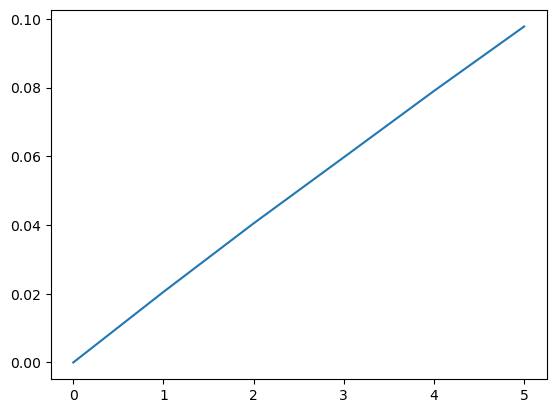

In [46]:
dates = [ql.WeekendsOnly().advance(trade_date, t * ql.Period(ql.Years)) for t in range(0, 6)]
pd.Series([probabilityCurve.defaultProbability(date) for date in dates]).plot()

0.0